# Lesson 3: Multi-objective optimization and ion channel diversity

## Lesson goals:

1. An approach to Lesson 2 Challenge 2a: Optimize f-I slope
2. An approach to Lesson 2 Challenge 2: Multi-objective optimization of somatic input resistance and f-I slope
3. Discuss papers from Lesson 2
4. New ion channel mechanisms: nax, kdr, and kap
5. Try multi-objective optimization again with new ion channels
6. For next week: papers focusing on spatial and temporal summation of synaptic input

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from neuron import h
h.load_file('stdrun.hoc')

1.0

### A pythonic aside: lambda functions and a convenient datatype: the defaultdict

<IPython.core.display.Javascript object>


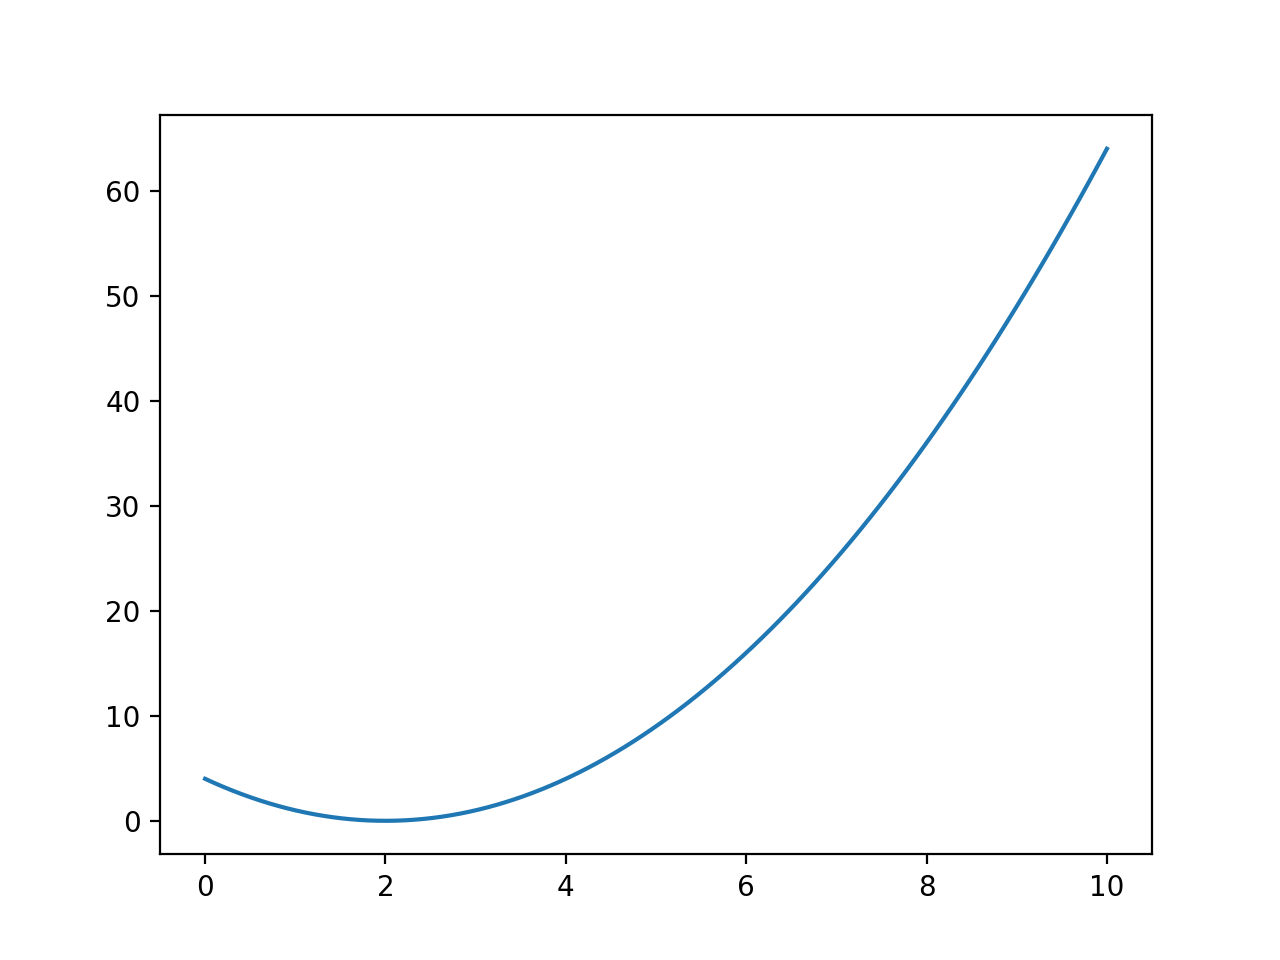

In [2]:
# A standard way to define a callable function with input arguments is:
def func_with_overhead(x):
    return (x - 2.) ** 2.

x = np.linspace(0., 10., 100)
plt.figure()
plt.plot(x, func_with_overhead(x))

<IPython.core.display.Javascript object>


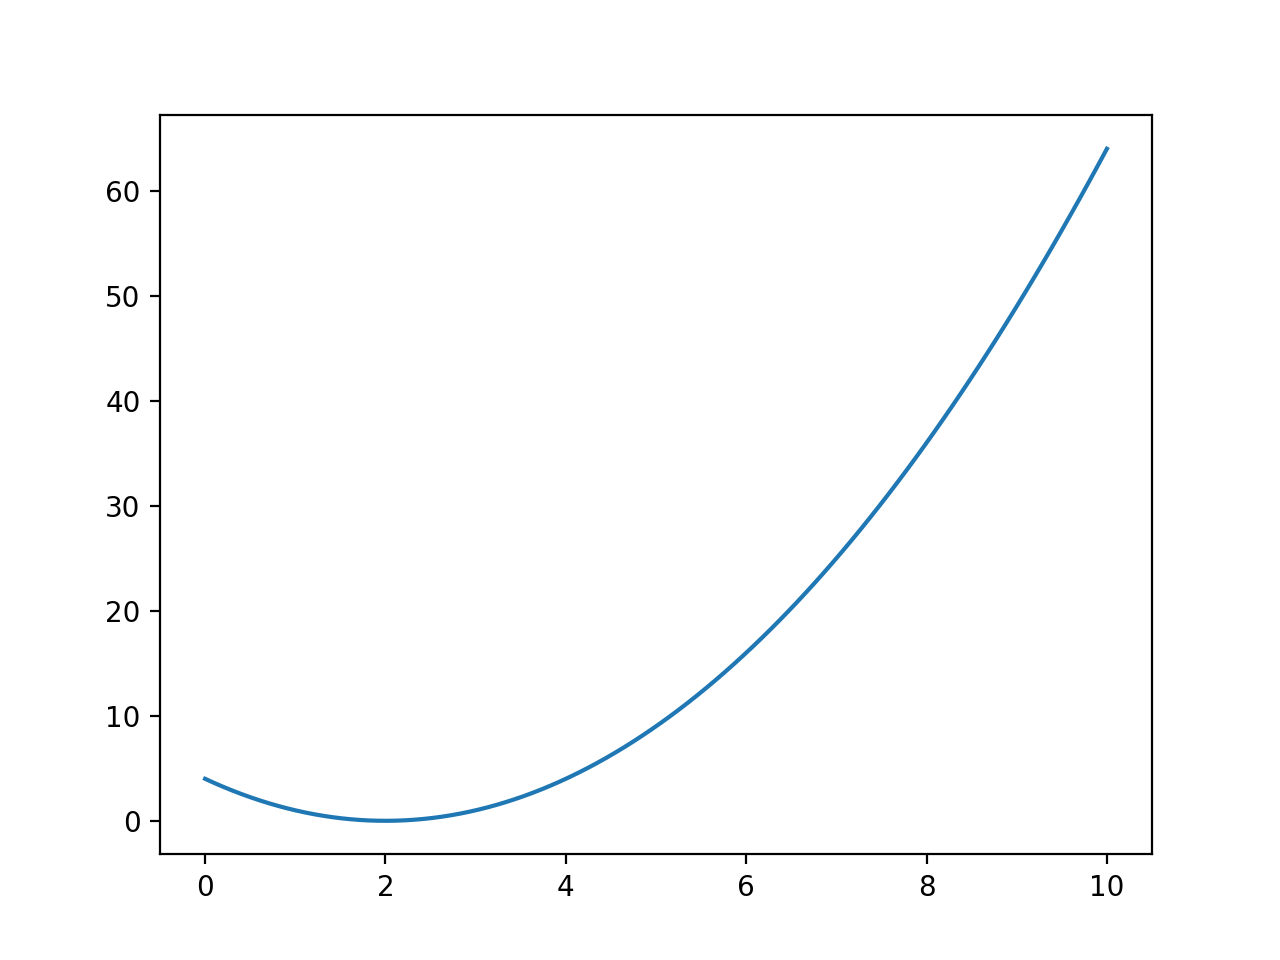

In [3]:
# An alternative way to create simple callable is:
func_light = lambda x: (x - 2.) ** 2.

plt.figure()
plt.plot(x, func_light(x))

### defaultdict: Great for building data structures with nested dictionaries and lists

In [4]:
from collections import defaultdict

### Great for building data structures with nested dictionaries and lists

In [5]:
standard_dict = {}
standard_dict['Aaron']['gender'] = 'Male'

KeyError: 'Aaron'

In [6]:
if 'Aaron' not in standard_dict:
    standard_dict['Aaron'] = {}
standard_dict['Aaron']['gender'] = 'Male'

print(standard_dict)

{'Aaron': {'gender': 'Male'}}


In [7]:
convenient_nested_dict = defaultdict(dict)
convenient_nested_dict['Aaron']['gender'] = 'Male'

print(convenient_nested_dict)

defaultdict(<class 'dict'>, {'Aaron': {'gender': 'Male'}})


In [8]:
convenient_dict_of_dict_of_list = defaultdict(lambda: defaultdict(list))  # defaultdicts have to be constructed with a callable

In [9]:
convenient_dict_of_dict_of_list['Aaron']['favorite colors'].extend(['Blue', 'Green', 'Red'])

print(convenient_dict_of_dict_of_list)

defaultdict(<function <lambda> at 0x7f81f2600560>, {'Aaron': defaultdict(<class 'list'>, {'favorite colors': ['Blue', 'Green', 'Red']})})


## 1. An approach to Lesson 2 Challenge 2a: Optimize f-I slope

In [10]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('hh')

h.tstop = 600.
v_init = -65.
h.v_init = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
f_I_stim_dur = 200.
f_I_stim_delay = 200.
f_I_stim_amp_list = [0.05 * i for i in range(10)]

R_inp_stim_dur = 200.
R_inp_stim_delay = 200.
R_inp_stim_amp = -0.1

gkbar0 = soma(0.5).hh.gkbar
gnabar0 = soma(0.5).hh.gnabar
gl0 = soma(0.5).hh.gl

spike_times = h.Vector()
spike_detector = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
spike_detector.delay = 0.  # ms
spike_detector.threshold = -10.  # mV
spike_detector.record(spike_times)

0.0

### Now we can use defaultdict to flexibly store a simulation_history for multiple objectives

In [11]:
from scipy.stats import linregress

sim_history = defaultdict(lambda: defaultdict(dict))


sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA


def simulate_f_I(stim_params):
    sim_summary_list = []
    step_current_stim.delay = stim_params['f_I']['delay']  # start time of current injection
    step_current_stim.dur = stim_params['f_I']['dur']  # duration in milliseconds
    for stim_amp in stim_params['f_I']['amp_list']:
        this_sim_summary = {}
        step_current_stim.amp = stim_amp
        this_sim_summary['stim_amp'] = stim_amp
        this_sim_summary['stim_delay'] = stim_params['f_I']['delay']
        this_sim_summary['stim_dur'] = stim_params['f_I']['dur']
        h.run()
        this_sim_summary['t'] = np.array(t)
        this_sim_summary['soma_voltage'] = np.array(soma_voltage)
        this_spike_times = np.array(spike_times)
        this_sim_summary['spike_times'] = this_spike_times
        
        # take only spike times occurring inside the current injection
        valid_spike_indexes = np.where((this_spike_times > f_I_stim_delay) & (this_spike_times <= f_I_stim_delay + f_I_stim_dur))[0]
        this_sim_summary['spike_count'] = len(valid_spike_indexes)
        this_sim_summary['spike_rate'] = len(valid_spike_indexes) / (f_I_stim_dur / 1000.)  # convert ms to s
        sim_summary_list.append(this_sim_summary)
    
    return sim_summary_list


def fit_f_I_curve(stim_amp, spike_rate):
    stim_amp_array = np.array(stim_amp)
    spike_rate_array = np.array(spike_rate)
    valid_stim_indexes = np.where(spike_rate_array > 0.)[0]
    if len(valid_stim_indexes) < 2:
        return 0., 0.
    slope, intercept, r_value, p_value, std_err = linregress(stim_amp_array[valid_stim_indexes], spike_rate_array[valid_stim_indexes])
    
    return slope, intercept


def get_f_I_slope_error(x, target, bounds, sim_history, stim_params):
    # enforce bounds:
    for xi, bi in zip(x, bounds):
        if not bi[0] <= xi <= bi[1]:
            return 1e9
    
    update_model(x)
    
    # simulate f_I and retrieve the data
    this_f_I_sim_summary_list = simulate_f_I(stim_params)
    
    # calculate the f_I slope
    this_spike_rate_list = [this_f_I_sim_summary['spike_rate'] for this_f_I_sim_summary in this_f_I_sim_summary_list]
    this_stim_amp_list = stim_params['f_I']['amp_list']
    this_f_I_slope, this_f_I_intercept = fit_f_I_curve(this_stim_amp_list, this_spike_rate_list)
    
    # calculate the squared error
    this_f_I_error = (this_f_I_slope - target['f_I_slope']) ** 2.
    
    sim_history[tuple(x)]['f_I']['data'] = this_f_I_sim_summary_list
    sim_history[tuple(x)]['f_I']['slope'] = this_f_I_slope
    sim_history[tuple(x)]['f_I']['intercept'] = this_f_I_intercept
    sim_history[tuple(x)]['f_I']['error'] = this_f_I_error
    
    return this_f_I_error


def update_model(x):
    # parse the input parameters
    gnabar, gkbar = x
    
    # modify the model to simulate f_I
    soma(0.5).hh.gnabar = gnabar
    soma(0.5).hh.gkbar = gkbar
    
    
fit_line = lambda x, slope, intercept: x * slope + intercept

### Let's make sure our functions work:

In [12]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA

stim_params = {'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list}}

error = get_f_I_slope_error(x0, target, bounds, sim_history, stim_params)
print('x0:', x0, 'bounds:', bounds, 'error:', error)

x0: [0.12, 0.036] bounds: [(0.012, 1.2), (0.0036, 0.36)] error: 100.00000000000057


<IPython.core.display.Javascript object>


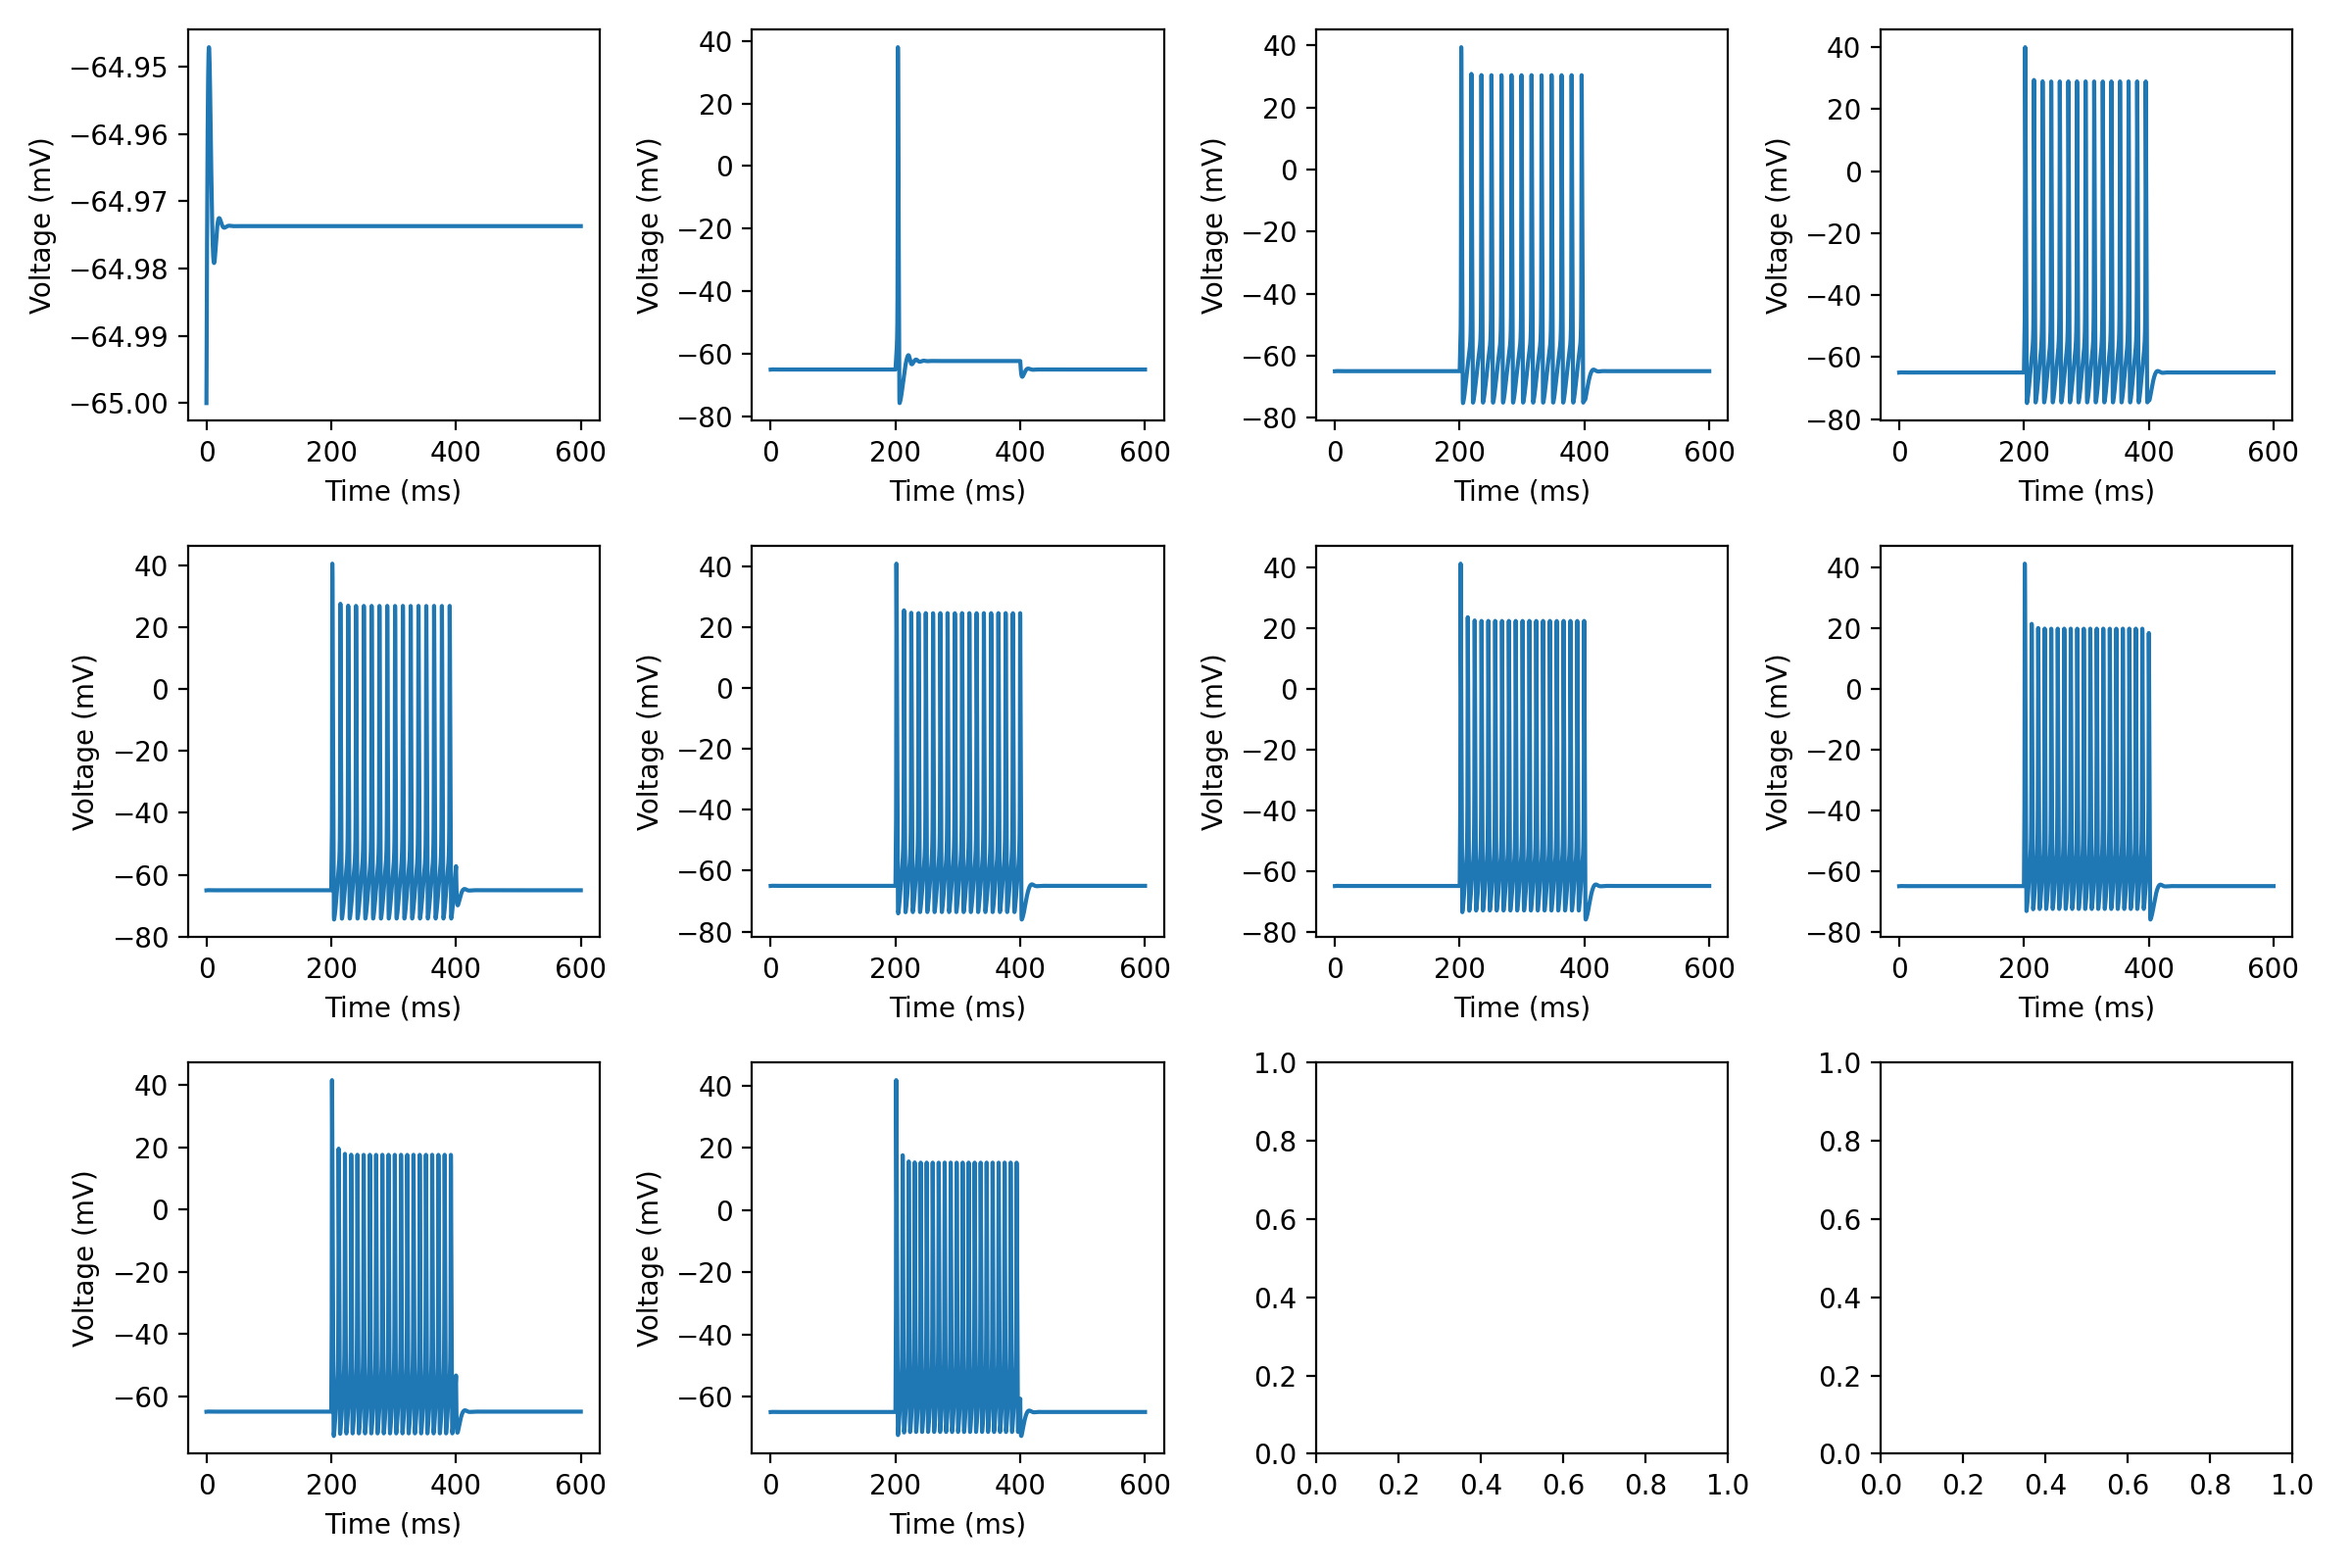

<IPython.core.display.Javascript object>


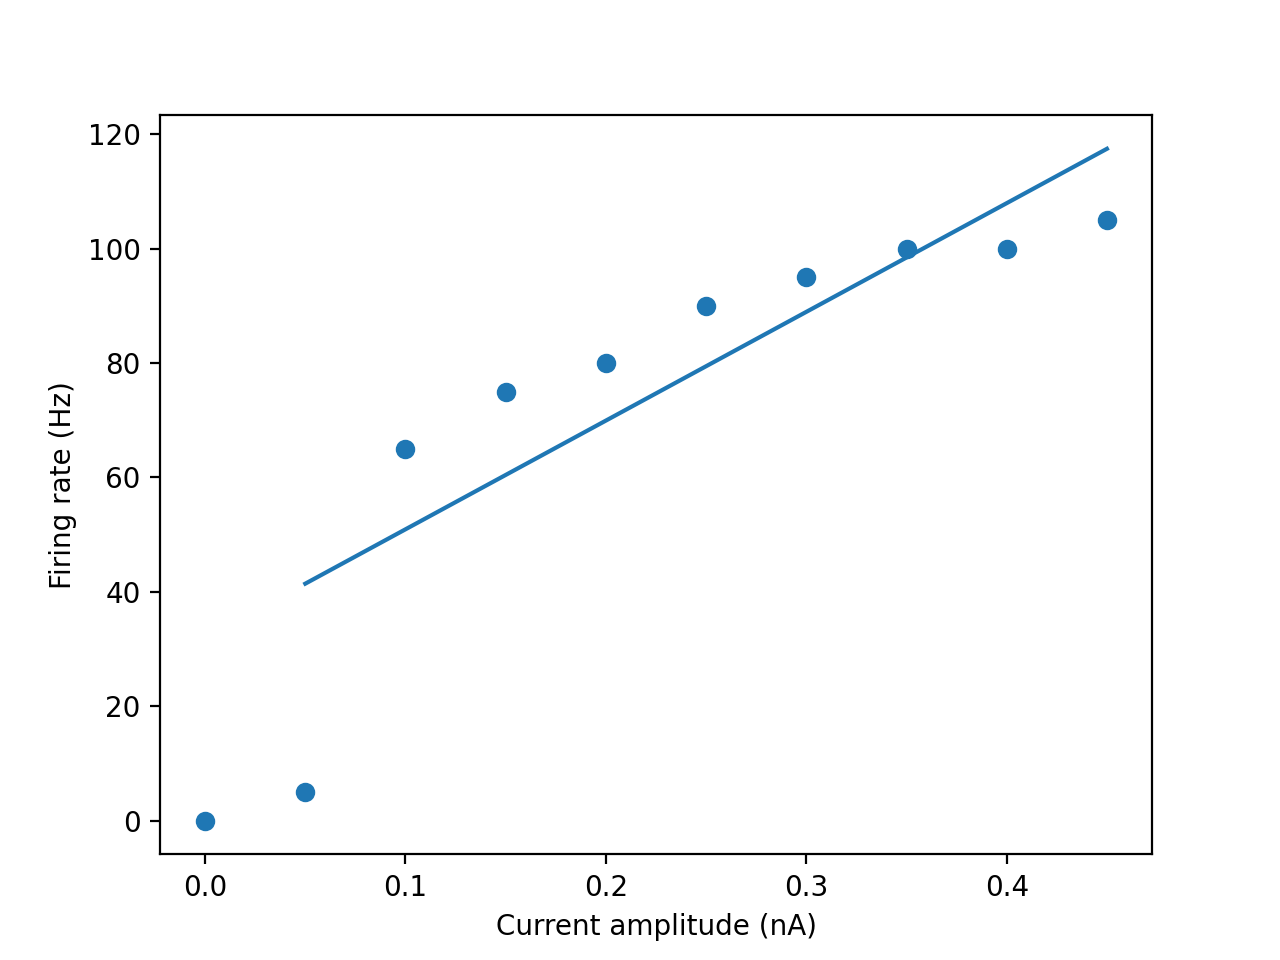

Slope: 189.99999999999997 Error: 100.00000000000057


In [13]:
this_x = x0

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

### Let's try a gradient-based optimization algorithm:

In [ ]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA

stim_params = {'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list}}

result = minimize(get_f_I_slope_error, x0, options={'disp': 1}, bounds=bounds, method='L-BFGS-B', args=(target, bounds, sim_history, stim_params))
print(result)

In [ ]:
this_x = result.x

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

### How about simplex?

In [ ]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA

stim_params = {'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list}}

result = minimize(get_f_I_slope_error, x0, options={'disp': True}, method='Nelder-Mead', args=(target, bounds, sim_history, stim_params))
print(result)

In [ ]:
this_x = result.x

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

## 2. An approach to Lesson 2 Challenge 2: Multi-objective optimization of somatic input resistance and f-I slope

In [14]:
def calculate_R_inp(t, v, i_amp, baseline_window=(195., 200.),  measurement_window=(395., 400.)):
    baseline_indexes = np.where((baseline_window[0] <= t) & (t < baseline_window[1]))
    measurement_indexes = np.where((measurement_window[0] <= t) & (t < measurement_window[1]))
    baseline_v = np.mean(v[baseline_indexes])
    measurement_v = np.mean(v[measurement_indexes])
    delta_v = abs(baseline_v - measurement_v)
    R_inp = (delta_v / 1000.) / (abs(i_amp) / 1e9) / 1e6 # convert mV to V, nA to A, and Ohm to MegaOhm
    return R_inp


def simulate_soma_R_inp(stim_params):
    step_current_stim.delay = stim_params['R_inp']['delay']
    step_current_stim.dur = stim_params['R_inp']['dur']
    step_current_stim.amp = stim_params['R_inp']['amp']
    this_sim_summary = {}
    this_sim_summary['stim_delay'] = stim_params['R_inp']['delay']
    this_sim_summary['stim_dur'] = stim_params['R_inp']['dur']
    this_sim_summary['stim_amp'] = stim_params['R_inp']['amp']
    
    h.run()
    t_array = np.array(t)
    v_array = np.array(soma_voltage)
    soma_R_inp = calculate_R_inp(t_array, v_array, stim_params['R_inp']['amp'])
    
    this_sim_summary['t'] = t_array
    this_sim_summary['soma_voltage'] = v_array
    this_sim_summary['soma_R_inp'] = soma_R_inp
    
    return [this_sim_summary]  # for consistency with f_I functions, return a list of simulation summary dictionaries


def get_soma_R_inp_error(x, target, bounds, sim_history, stim_params):
    # enforce bounds
    for xi, bi in zip(x, bounds):
        if not bi[0] <= xi <= bi[1]:
            return 1e9
        
    update_model(x)
    
    this_R_inp_sim_summary_list = simulate_soma_R_inp(stim_params)
    this_soma_R_inp = this_R_inp_sim_summary_list[0]['soma_R_inp']
    
    # calculate the squared error
    this_R_inp_error = (this_soma_R_inp - target['soma_R_inp']) ** 2.
    
    sim_history[tuple(x)]['R_inp']['data'] = this_R_inp_sim_summary_list
    sim_history[tuple(x)]['R_inp']['soma_R_inp'] = this_soma_R_inp
    sim_history[tuple(x)]['R_inp']['error'] = this_R_inp_error
    
    return this_R_inp_error


def update_model(x):
    # parse the input parameters
    gnabar, gkbar, gl = x
    
    soma(0.5).hh.gl = gl
    soma(0.5).hh.gnabar = gnabar
    soma(0.5).hh.gkbar = gkbar
    
    
def get_excitability_error(x, target, bounds, sim_history, stim_params):
    this_R_inp_error = get_soma_R_inp_error(x, target, bounds, sim_history, stim_params)
    this_f_I_slope_error = get_f_I_slope_error(x, target, bounds, sim_history, stim_params)
    
    return this_R_inp_error + this_f_I_slope_error

### Let's make sure our new functions work:

In [15]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
              }

error = get_soma_R_inp_error(x0, target, bounds, sim_history, stim_params)
print('x0:', x0, 'bounds:', bounds, 'error:', error)

x0: [0.12, 0.036, 0.0003] bounds: [(0.012, 1.2), (0.0036, 0.36), (2.9999999999999997e-05, 0.0029999999999999996)] error: 53.51002274424799


<IPython.core.display.Javascript object>


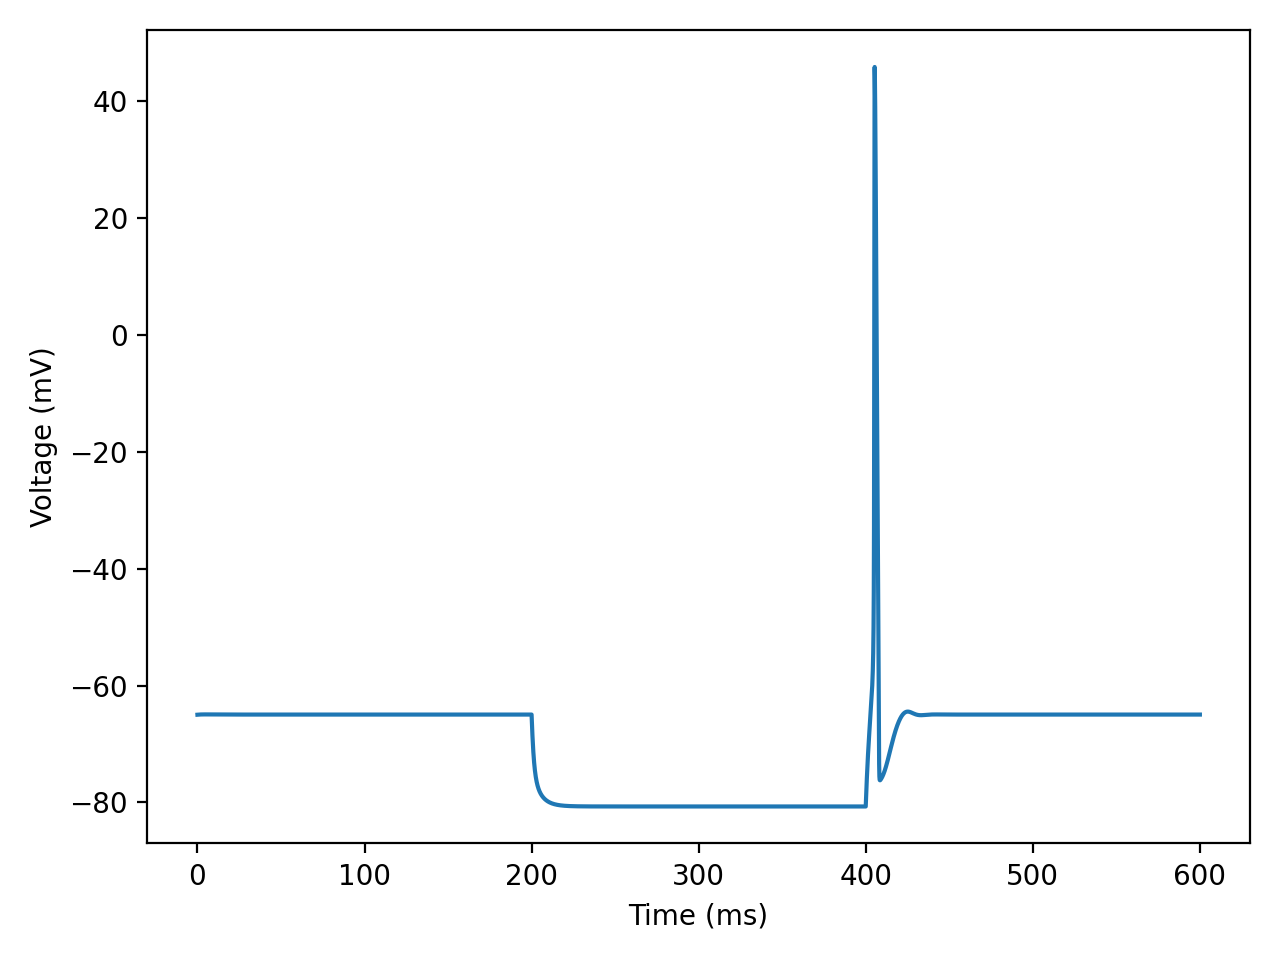

soma_R_inp: 157.31505452776997 Error: 53.51002274424799


In [16]:
this_x = x0

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

## Multi-objective optimization!

In [ ]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkbar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
              }

result = minimize(get_excitability_error, x0, options={'disp': True}, method='Nelder-Mead', args=(target, bounds, sim_history, stim_params))
print(result)

In [ ]:
this_x = result.x

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

## 3. Discuss papers from Lesson 2

A nice paper/blog about "how to read a paper": https://www.open.edu/openlearn/science-maths-technology/introduction-software-development/content-section-8.1.3

## 4. New ion channel mechanisms: nax, kdr, and kap

### First, let's take a look at the .mod files, and run `nrnivmodl` to compile them.

In [17]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('pas')  # leak
soma.insert('kdr')  # delayed-rectifier K+ channel
soma.insert('kap')  # A-type K+ channel
soma.insert('nax')  # Na+ channel

h.celsius = 35.  # These mechanisms are meant to work at (closer to) physiological temperature
h.tstop = 600.
v_init = -65.
h.v_init = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
f_I_stim_dur = 200.
f_I_stim_delay = 200.
f_I_stim_amp_list = [0.05 * i for i in range(10)]

R_inp_stim_dur = 200.
R_inp_stim_delay = 200.
R_inp_stim_amp = -0.1

soma(0.5).pas.e = -65.
gl0 = soma(0.5).pas.g
gkdrbar0 = soma(0.5).kdr.gkdrbar
gkabar0 = soma(0.5).kap.gkabar
gnabar0 = soma(0.5).nax.gbar

spike_times = h.Vector()
spike_detector = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
spike_detector.delay = 0.  # ms
spike_detector.threshold = -10.  # mV
spike_detector.record(spike_times)

0.0

### Let's edit our update_model function to reflect the change in parameters:

In [18]:
def update_model(x):
    # parse the input parameters
    gnabar, gkdrbar, gkabar, gl = x
    
    soma(0.5).nax.gbar = gnabar
    soma(0.5).kdr.gkdrbar = gkdrbar
    soma(0.5).kap.gkabar = gkabar
    soma(0.5).pas.g = gl

### How does the model behave with the mechanism defaults?

In [19]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkdrbar0, gkabar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
              }

error = get_excitability_error(x0, target, bounds, sim_history, stim_params)
print('x0:', x0, 'bounds:', bounds, 'error:', error)

x0: [0.01, 0.003, 0.01, 0.001] bounds: [(0.001, 0.1), (0.00030000000000000003, 0.03), (0.001, 0.1), (0.0001, 0.01)] error: 45024.164541413906


<IPython.core.display.Javascript object>


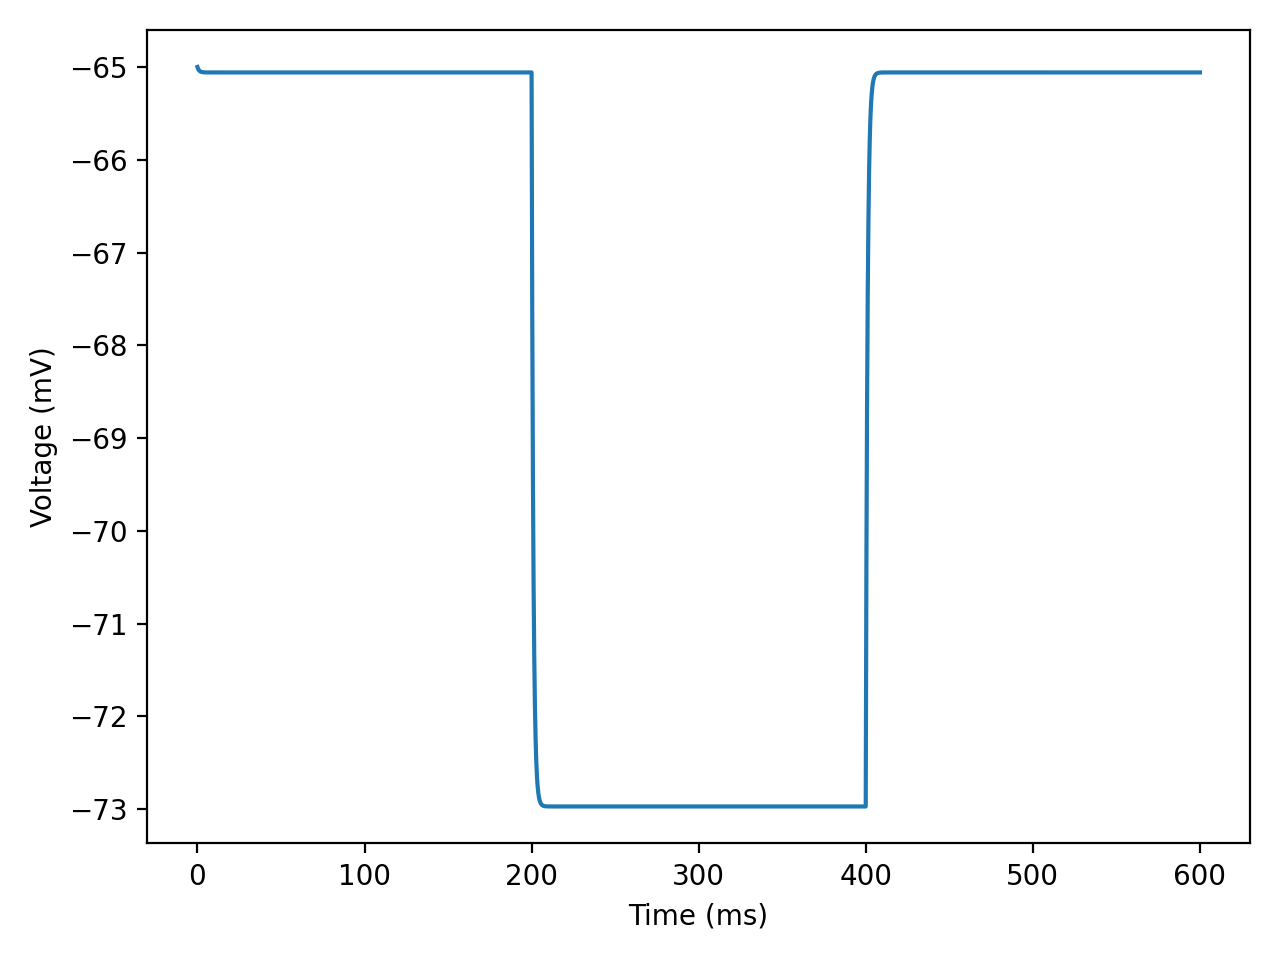

soma_R_inp: 79.11865872167836 Error: 5024.164541413904


<IPython.core.display.Javascript object>


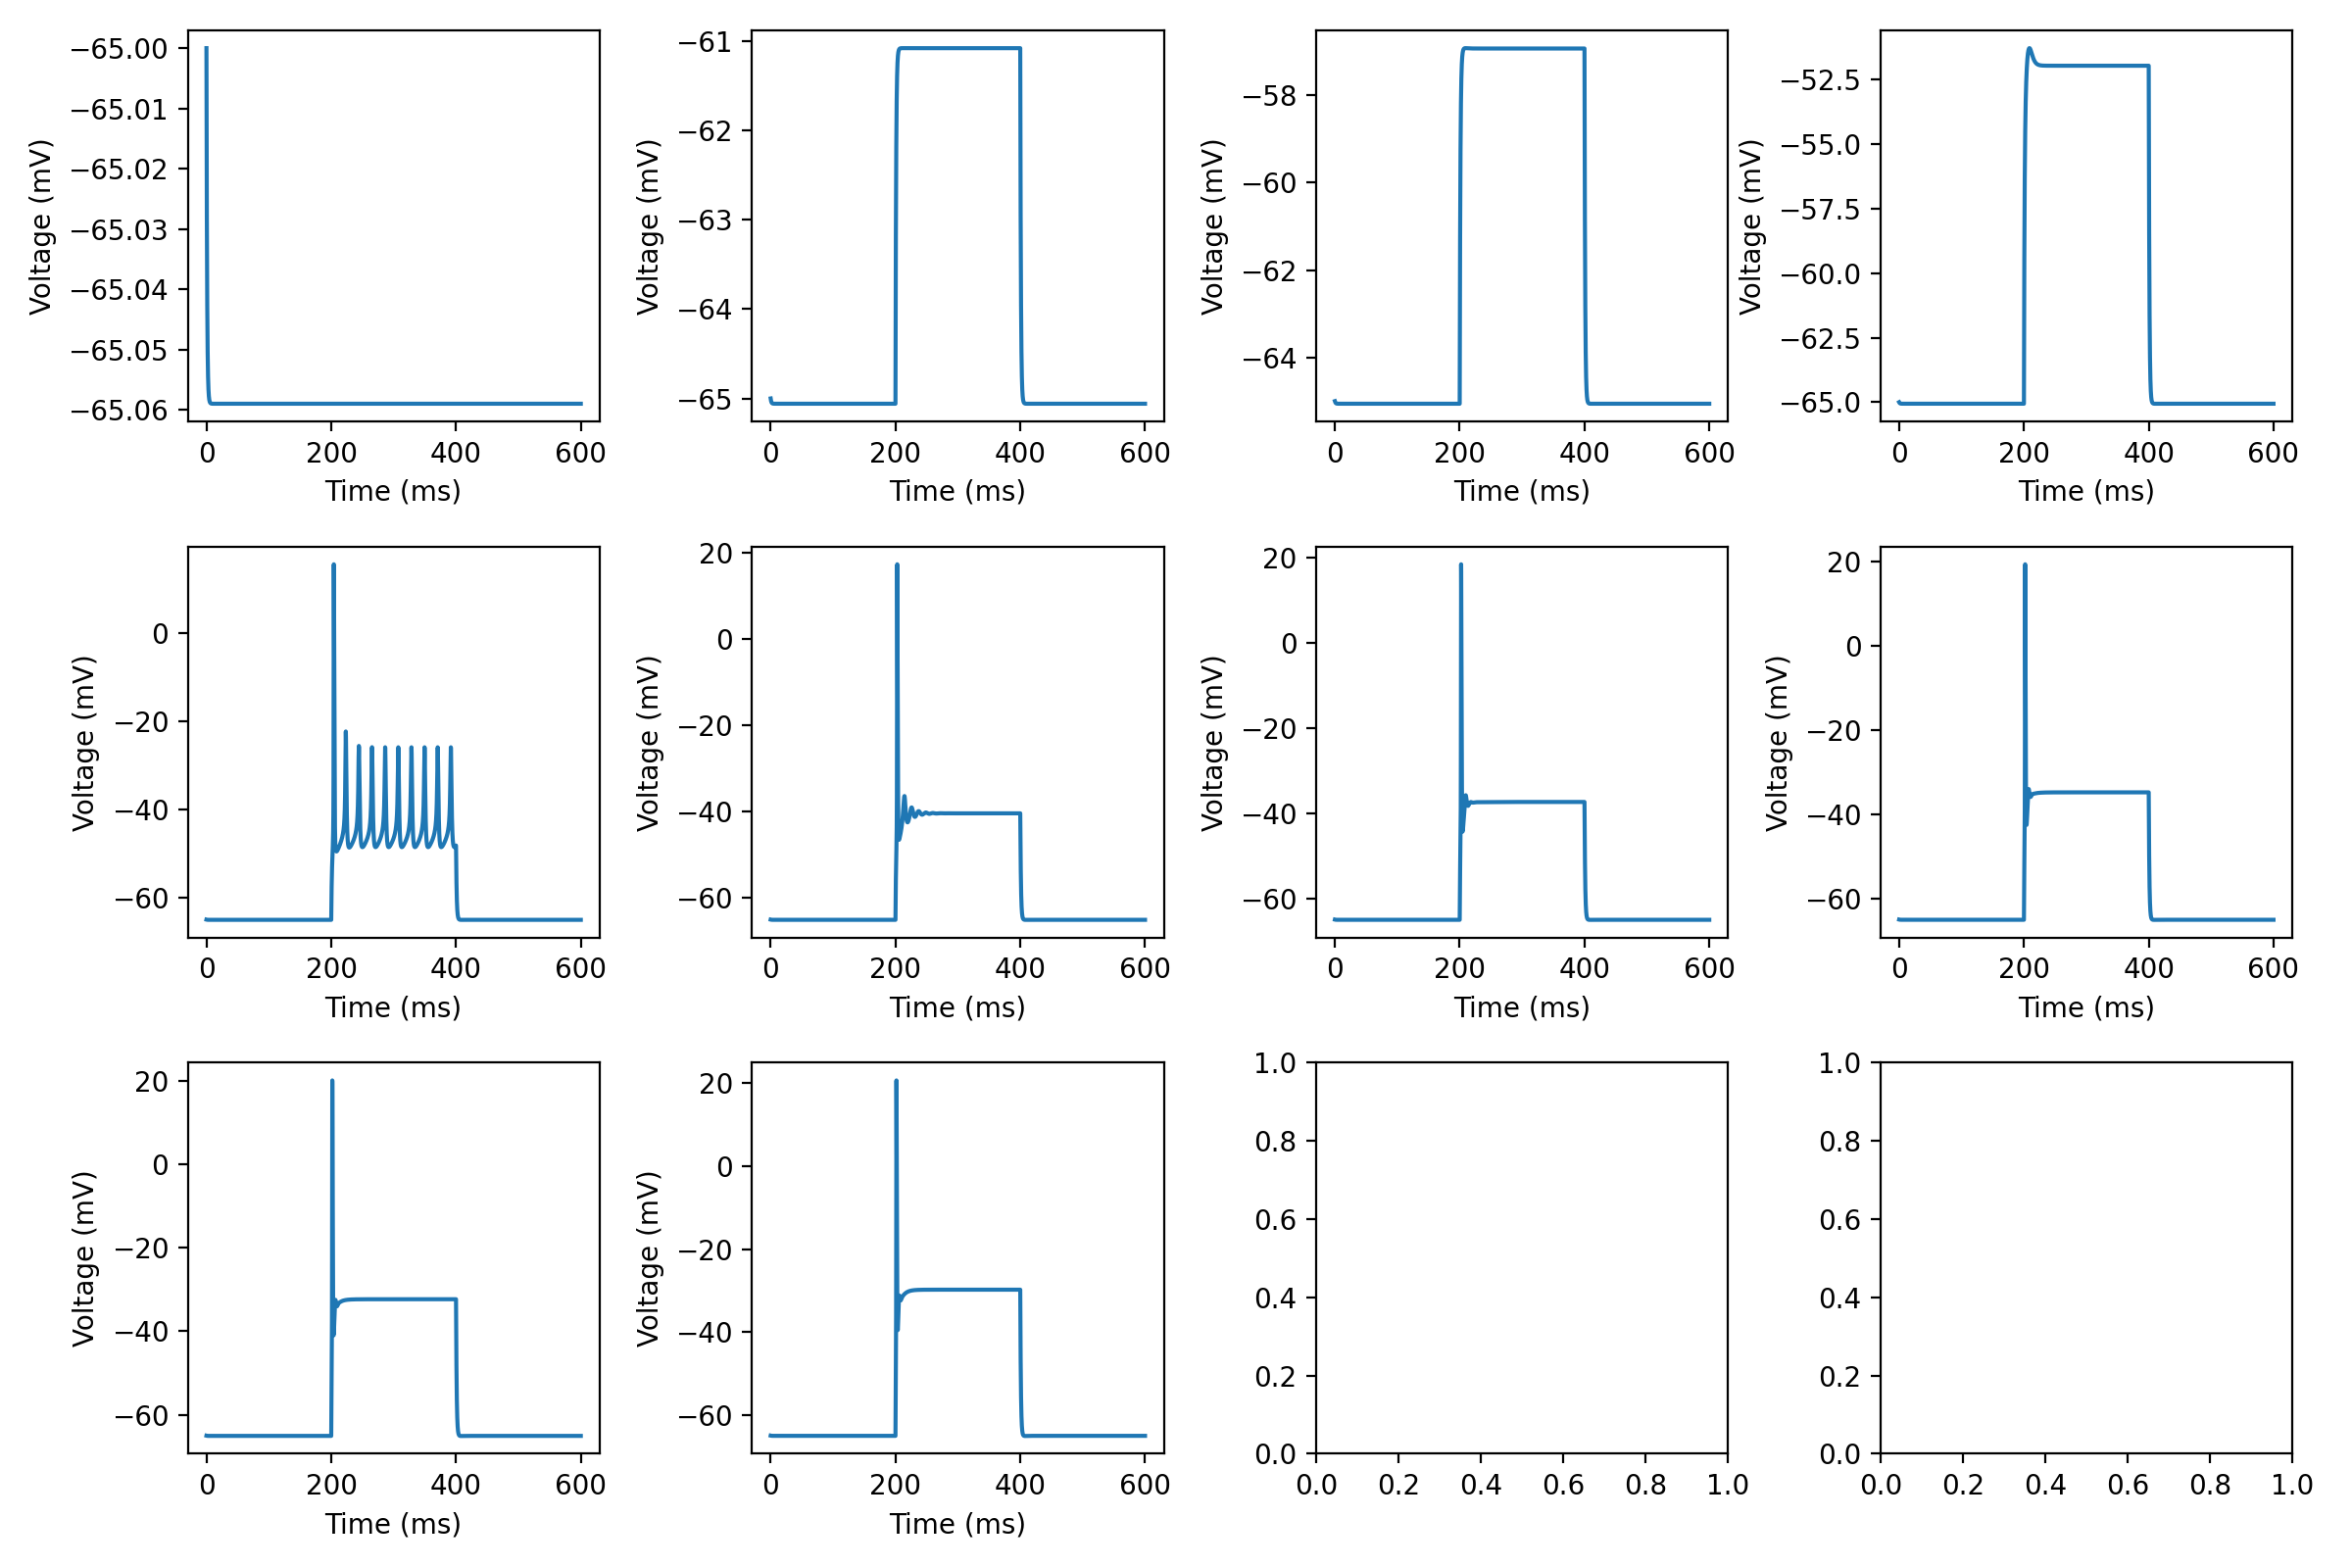

<IPython.core.display.Javascript object>


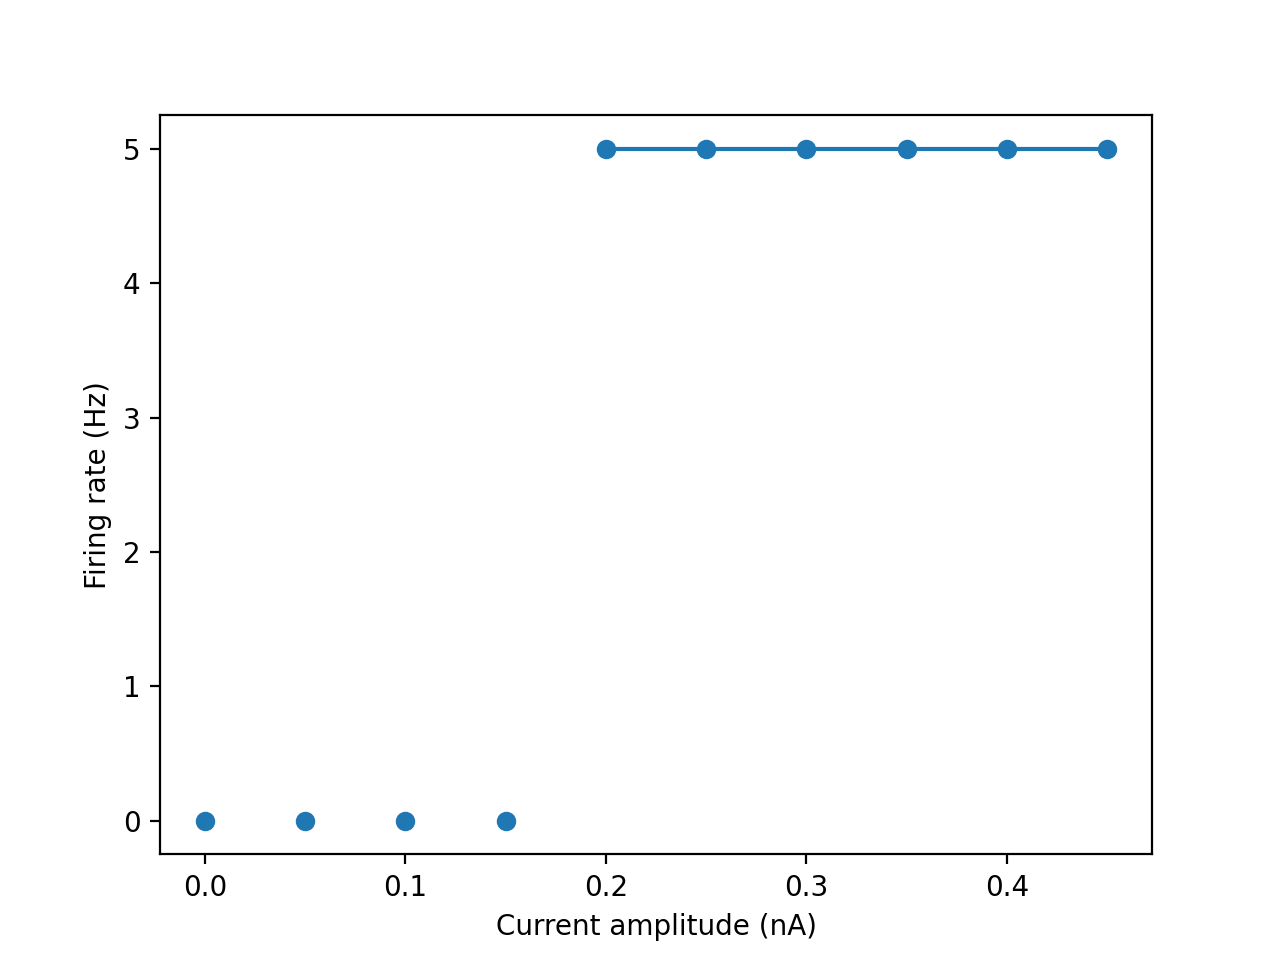

Slope: 0.0 Error: 40000.0


In [20]:
this_x = x0

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

In [21]:
sim_history

defaultdict(<function __main__.<lambda>()>,
            {(0.01, 0.003, 0.01, 0.001): defaultdict(dict,
                         {'R_inp': {'data': [{'stim_delay': 200.0,
                             'stim_dur': 200.0,
                             'stim_amp': -0.1,
                             't': array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 5.99950e+02,
                                    5.99975e+02, 6.00000e+02]),
                             'soma_voltage': array([-65.        , -65.00144542, -65.00285538, ..., -65.05895861,
                                    -65.05895861, -65.05895861]),
                             'soma_R_inp': 79.11865872167836}],
                           'soma_R_inp': 79.11865872167836,
                           'error': 5024.164541413904},
                          'f_I': {'data': [{'stim_amp': 0.0,
                             'stim_delay': 200.0,
                             'stim_dur': 200.0,
                             't': array([0.00000e+00, 2

## 5. Try multi-objective optimization again with new ion channels

In [ ]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkdrbar0, gkabar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
              }

result = minimize(get_excitability_error, x0, options={'disp': True}, method='Nelder-Mead', args=(target, bounds, sim_history, stim_params))
print(result)

In [ ]:
this_x = result.x

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

## How about basinhopping?

### First of all how can we use a different stepsize for different parameters with different bounds?

In [ ]:
class CustomTakeStep(object):
    def __init__(self, bounds, stepsize=0.5):
        self.bounds = bounds
        self.stepsize = stepsize
    def __call__(self, x):
        for i, bi in enumerate(self.bounds):
            this_stepsize = self.stepsize * (bi[1] - bi[0])
            x[i] += np.random.uniform(-this_stepsize, this_stepsize)
        return x

### Also, what if we don't want to use a local minimizer with multiple function evals with every iteration?

In [ ]:
from scipy.optimize import OptimizeResult
def null_minimizer(fun, x0, args, **options):
    return OptimizeResult(x=x0, fun=fun(x0, *args), success=True, nfev=1)

In [ ]:
sim_history = defaultdict(lambda: defaultdict(dict))
x0 = [gnabar0, gkdrbar0, gkabar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
    }

result = basinhopping(get_excitability_error, x0, disp=True, take_step=CustomTakeStep(bounds), niter=800, interval=40, 
                     minimizer_kwargs={'method': null_minimizer, 'args': (target, bounds, sim_history, stim_params)})
print(result)

In [ ]:
this_x = result.x

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

### Can we improve the basinhopping result by using the simplex algorithm to do some final polishing?

In [ ]:
# Let's keep alive the old sim_history for now
basinhopping_best_x = result.x
x0 = [gnabar0, gkdrbar0, gkabar0, gl0]
bounds = [(0.1*xi, 10.*xi) for xi in x0]

target = {}
target['f_I_slope'] = 200.  # Hz / nA
target['soma_R_inp'] = 150.  # MOhm

stim_params = {
    'f_I': {'delay': f_I_stim_delay, 'dur': f_I_stim_dur, 'amp_list': f_I_stim_amp_list},
    'R_inp': {'delay': R_inp_stim_delay, 'dur': R_inp_stim_dur, 'amp': R_inp_stim_amp}
              }

result = minimize(get_excitability_error, basinhopping_best_x, options={'disp': True}, method='Nelder-Mead', args=(target, bounds, sim_history, stim_params))
print(result)

In [ ]:
this_x = result.x

fig, axis = plt.subplots()
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['R_inp']['data']):
    axis.plot(sim_summary['t'], sim_summary['soma_voltage'])
    axis.set_ylabel('Voltage (mV)')
    axis.set_xlabel('Time (ms)')
fig.tight_layout()

print('soma_R_inp:', sim_history[tuple(this_x)]['R_inp']['soma_R_inp'], 'Error:', sim_history[tuple(this_x)]['R_inp']['error'])

fig, axes = plt.subplots(3, 4, figsize=(12., 8.))
for i, sim_summary in enumerate(sim_history[tuple(this_x)]['f_I']['data']):
    axes.flat[i].plot(sim_summary['t'], sim_summary['soma_voltage'])
    axes.flat[i].set_ylabel('Voltage (mV)')
    axes.flat[i].set_xlabel('Time (ms)')
fig.tight_layout()

this_slope = sim_history[tuple(this_x)]['f_I']['slope']
this_intercept = sim_history[tuple(this_x)]['f_I']['intercept']
stim_amp_array = np.array([sim_summary['stim_amp'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
spike_rate_array = np.array([sim_summary['spike_rate'] for sim_summary in sim_history[tuple(this_x)]['f_I']['data']])
valid_stim_indexes = np.where(spike_rate_array > 0.)[0]

plt.figure()
plt.scatter(stim_amp_array, spike_rate_array)
plt.plot(stim_amp_array[valid_stim_indexes], fit_line(stim_amp_array[valid_stim_indexes], this_slope, this_intercept))
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Current amplitude (nA)')
plt.show()

print('Slope:', sim_history[tuple(this_x)]['f_I']['slope'], 'Error:', sim_history[tuple(this_x)]['f_I']['error'])

## 6. For next week: papers focusing on spatial and temporal summation of synaptic input

- Magee, J., Cook, E. (2000). Somatic EPSP amplitude is independent of synapse location in hippocampal pyramidal neurons Nature Neuroscience  3(9), 895-903. https://dx.doi.org/10.1038/78800
- Magee, J. Dendritic Ih normalizes temporal summation in hippocampal CA1 neurons. Nat Neurosci 2, 508–514 (1999). https://doi.org/10.1038/9158
- Bianchi, D., Marasco, A., Limongiello, A., Marchetti, C., Marie, H., Tirozzi, B., Migliore, M. (2012). On the mechanisms underlying the depolarization block in the spiking dynamics of CA1 pyramidal neurons Journal of Computational Neuroscience  33(2), 207-225. https://dx.doi.org/10.1007/s10827-012-0383-y